In [27]:
import pandas as pd 
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline


In [28]:
def load_data(_base_path):
    _test_data = pd.read_csv(_base_path + '测试集.csv')
    _train_data =  pd.read_csv(_base_path + '训练集.csv')
    y = _train_data['satisfaction_level']  
    _train_data.drop(['satisfaction_level'], axis=1, inplace=True)
    _data = pd.concat([_train_data,_test_data],ignore_index=True)
    return _data, y
base_path = 'E:/python/data/训练赛/人力资源分析/Employee_Satisfaction/'
data, Y = load_data(base_path)


In [29]:
def feature_engineering(_data):
    standed = ['average_monthly_hours','time_spend_company','number_project', 'a1','a2','a3','a4','a5']
    _data['a1'] = _data['time_spend_company'] * _data['average_monthly_hours'] * 12
    _data['a2'] = _data['number_project'] * 356 / _data['a1']
    _data['a3'] = _data['number_project'] / _data['time_spend_company']
    _data['a4'] = _data['salary'] * 2000 / _data['time_spend_company']
    _data['a5'] = _data['salary'] *2000 / _data['average_monthly_hours']
    for i in standed:
        _data[i] = _data[i]/(_data[i].max()-_data[i].min())
    
    return _data

In [30]:
def processing_data(_data):
    dispersed_feature = ['package','division','salary']
    for fea in dispersed_feature:
        le = LabelEncoder()
        _data[fea] = le.fit_transform(_data[fea].values)
        
    _data = feature_engineering(_data)
    
    _submit_id = _data.loc[11999:,'id']
    _data.drop('id', axis=1, inplace=True)
    _X = _data.loc[:11998,:]
    _P = _data.loc[11999:,:]
    return _submit_id, _X, _P
submit_id, X, P = processing_data(data)

[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[400]	valid_0's l2: 0.026565
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[400]	valid_0's l2: 0.0254183
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[400]	valid_0's l2: 0.0265518
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[400]	valid_0's l2: 0.0271725
[LightGBM] [Warning] lambda_l2 is set=2, 

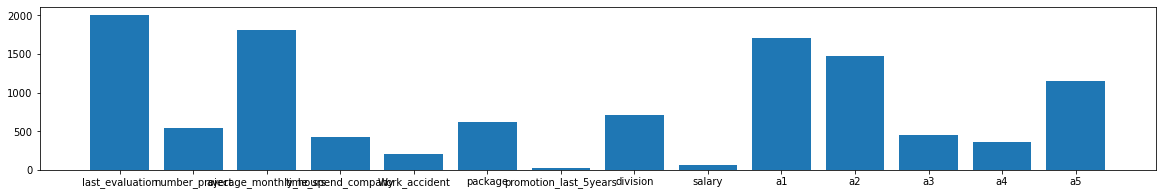

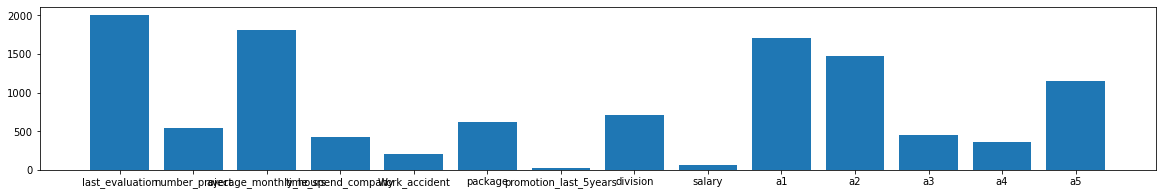

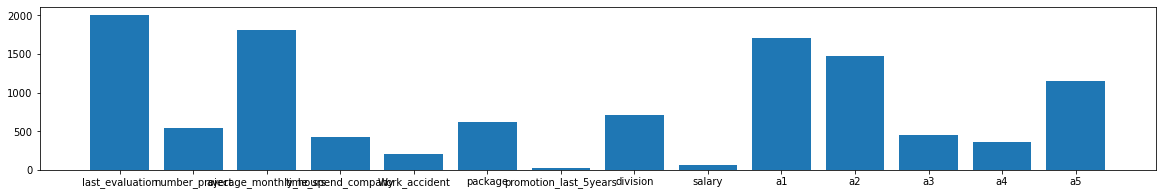

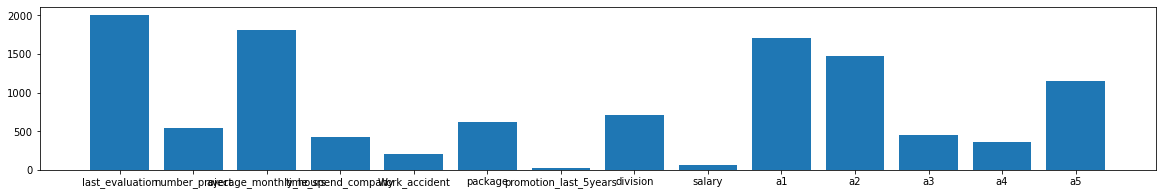

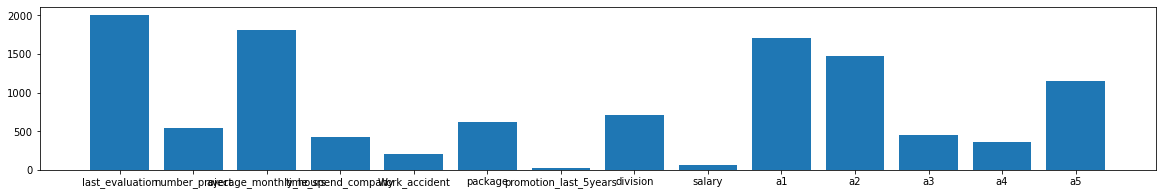

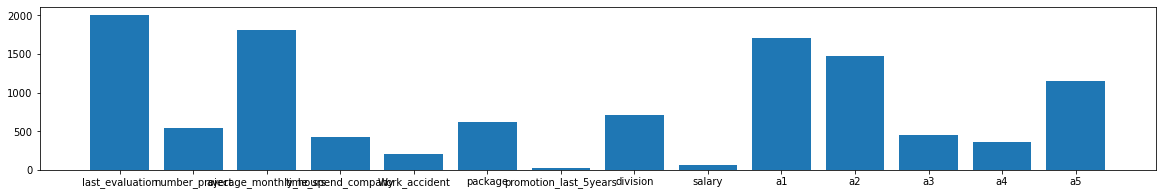

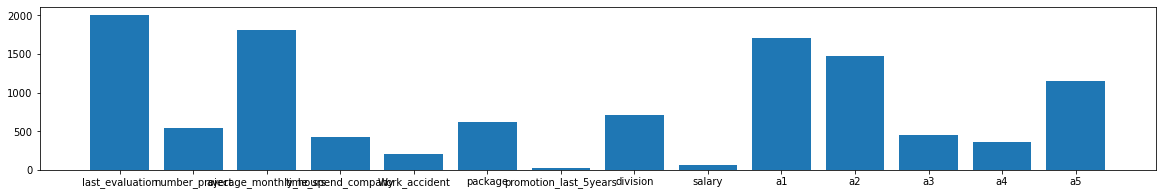

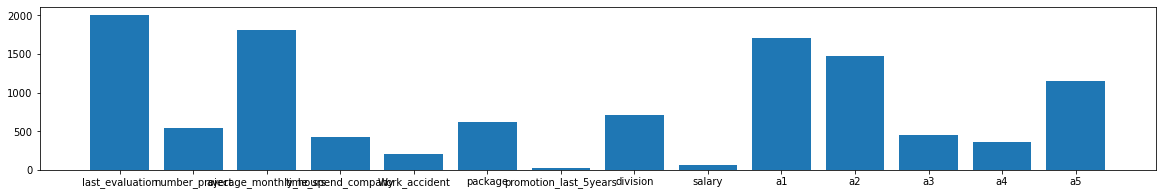

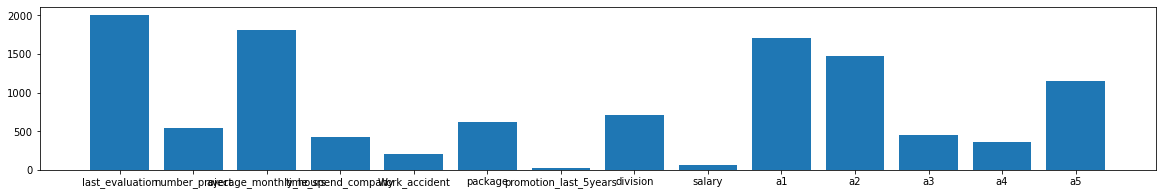

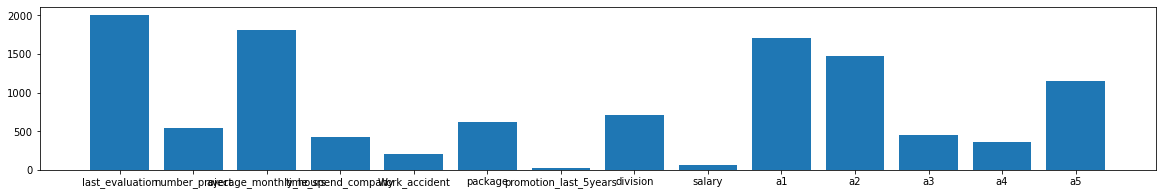

In [36]:
def model(X, Y, P):
    pre = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=2020*i)
        model = LGBMRegressor(num_leaves=30, max_depth=10, n_estimators=400, learning_rate=0.02, verbose=-1,
                   metric='l2', random_state=330*i, lambda_l2=8)
        model.fit(X,Y,eval_set=[(X_test, y_test)], early_stopping_rounds=200, verbose=500)
        plt.figure(figsize=(20,3))
        plt.bar(X_train.columns, model.feature_importances_)
        res = model.predict(P)
        pre.append(res)
    pre = np.array(pre).mean(axis=0)
    return pre
pre_y  =model(X,Y,P)

In [37]:

pd.Series(pre_y, index=submit_id,name='satisfaction_level').to_csv(base_path + 'submit.csv')